### Example: Ideal gas
We setup a system of non-interacting particles, run a short simulation, and examine the resulting trajectory.

In [19]:
import h5py
import numpy as np


def setup_system(box_size, number_density, out_path):
    """Setup a simple system of independent particles with no bonds
    
    Parameters
    ----------
    box_size : list of float
        Simulation box size in nm.
    number_density : float
        Number density per nm squared of particles in the simulation box.
    out_path : str
        Path of the created structure file.
    """
    box_size = np.asarray(box_size, dtype=np.float32)
    volume = np.prod(box_size)
    n_particles = int(number_density * volume)
    
    with h5py.File(out_path, "w") as out_file:
        position_dataset = out_file.create_dataset(
            "coordinates",
            (1, n_particles, box_size.size,),
            dtype="float32",
        )
        types_dataset = out_file.create_dataset(
            "types",
            (n_particles,),
            dtype="i",
        )
        names_dataset = out_file.create_dataset(
            "names",
            (n_particles,),
            dtype="S10",
        )
        indices_dataset = out_file.create_dataset(
            "indices",
            (n_particles,),
            dtype="i",
        )
        
        types_dataset[...] = 0
        names_dataset[...] = np.string_("A")
        indices_dataset[...] = np.arange(n_particles)
        position_dataset[...] = np.random.uniform(
            low=0.0, high=box_size, size=(1, n_particles, box_size.size),
        )
    

# 125 particles in a 5nm x 5nm x 5nm simulation box.
setup_system([5, 5, 5], 1.0, "ideal_gas.HDF5")

### Run the simulation
Disable the field interactions with `--disable-field` and make sure the velocity and forces are output to the trajectory file with `--velocity-output` and `--force-output`.
```bash
mpirun -n 6 python3 /Users/mortenledum/Documents/HyMD/hymd/__main__.py \
                    ideal_gas.toml    \
                    ideal_gas.HDF5    \
                    --disable-field   \
                    --velocity-output \
                    --force-output    \
                    --seed 1          \
                    --verbose 2
```

### Examine the trajectory

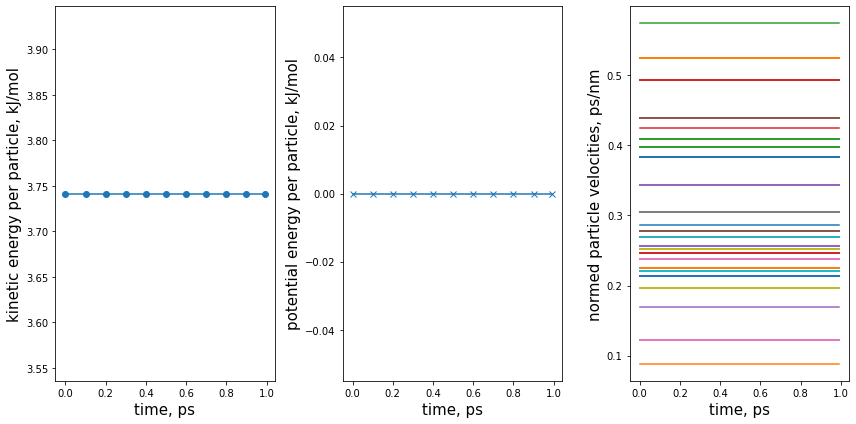

In [18]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File("sim.h5", "r") as in_file:
    time = in_file["/particles/all/position/time"][...]
    positions = in_file["/particles/all/position/value"][...]
    velocities = in_file["/particles/all/velocity/value"][...]
    forces = in_file["/particles/all/force/value"][...]
    kinetic_energy = in_file["/observables/kinetic_energy/value"][...]
    potential_energy = in_file["/observables/potential_energy/value"][...]
    n_particles = positions.shape[1]

fig, axs = plt.subplots(1, 3)
fig.set_figwidth(12)
fig.set_figheight(6)
font_opts = {"fontsize": 15}

axs[0].plot(time, kinetic_energy / n_particles, marker="o")
axs[0].set_ylabel("kinetic energy per particle, kJ/mol", **font_opts)

axs[1].plot(time, potential_energy / n_particles, marker="x")
axs[1].set_ylabel("potential energy per particle, kJ/mol", **font_opts)

axs[2].plot(time, np.linalg.norm(velocities, axis=2))
axs[2].set_ylabel("normed particle velocities, ps/nm", **font_opts)

for ax in axs:
    ax.set_xlabel("time, ps", **font_opts)
fig.tight_layout()
plt.show()